<a href="https://colab.research.google.com/github/ubermenchh/fun/blob/main/modern_compvis_pytorch_book/generating_cams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating CAMs

How to generate Class Activation Maps (CAMs)
1. Decide for which class you want to calculate the CAM and for which conv layer in the neural net you want to compute the CAM.
2. Calculate the activations arising from any conv layer - let's say the feature shape at a random conv layer is `512x7x7`.
3. Fetch the gradient values arising from this layer with respect to the class of interest. The output gradient shape is `256x512x3x3` (which is the shape of conv tensor - that is, `in_channels x out_channels x kernel_size x kernel_size`).
4. Compute the mean of the gradient s within each output channel. The output shape is 512.
5. Calculate the weighted activation map - which is the multiplication of the 512 gradient means by the 512 activation channels. The output shape is `512x7x7`.
6. Compute the mean (across 512 channels) of the weighted activation map to fetch an output of the shape `7x7`.
7. Resize (upscale) the weighted activation map outputs to fetch an image of a size that is of the same size as the input. This is done so that we have an activation map that resembles the original image.
8. Overlay the weighted activation map onto the input images.

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"umangkaushik","key":"867a1708bf189096f61c8e239ccfa2b7"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 97% 654M/675M [00:08<00:00, 85.3MB/s]
100% 675M/675M [00:08<00:00, 79.7MB/s]


In [4]:
!unzip -q cell-images-for-detecting-malaria.zip

In [6]:
!pip install -U -q torch_snippets
from torch_snippets import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 90.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 86.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 120.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 111.3 MB/s et

In [7]:
id2int = {'Parasitized': 0, 'Uninfected':1}

In [8]:
import torchvision.transforms as T

train_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(128),
    T.CenterCrop(128),
    T.ColorJitter(brightness=(0.95, 1.05), contrast=(0.95, 1.05),
                   saturation=(0.95, 1.05), hue=0.05),
    T.RandomAffine(5, translate=(0.01, 0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [9]:
val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(128),
    T.CenterCrop(128),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [10]:
class MalariaImages(Dataset):
    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        logger.info(len(self))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        fpath = self.files[ix]
        clss = fname(parent(fpath))
        img = read(fpath, 1)
        return img, clss

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self, batch):
        _imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in _imgs]
        classes = [torch.tensor([id2int[clss]]) for clss in classes]
        imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
        return imgs, classes,_imgs

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_files = Glob('/content/cell_images/*/*.png')
np.random.shuffle(all_files)

from sklearn.model_selection import train_test_split
train_files, valid_files = train_test_split(all_files)

train_ds = MalariaImages(train_files, transform=train_tfms)
valid_ds = MalariaImages(valid_files, transform=val_tfms)

train_dl = DataLoader(train_ds, 32, shuffle=True, collate_fn=train_ds.collate_fn)
valid_dl = DataLoader(valid_ds, 32, shuffle=True, collate_fn=valid_ds.collate_fn)

[11/03/23 16:47:13] INFO     20668                                                                                                ]8;id=76648;file://<ipython-input-10-0b0575b658bb>:5\<ipython-input-10-0b0575b658bb>]8;;\:]8;id=374409;file://<ipython-input-10-0b0575b658bb>:5#__init__:5\__init__:5]8;;\

                    INFO     6890                                                                                                 ]8;id=883663;file://<ipython-input-10-0b0575b658bb>:5\<ipython-input-10-0b0575b658bb>]8;;\:]8;id=182137;file://<ipython-input-10-0b0575b658bb>:5#__init__:5\__init__:5]8;;\

In [12]:
def conv_block(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2)
    )

In [13]:
class MalariaClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            conv_block(3, 64),
            conv_block(64, 64),
            conv_block(64, 128),
            conv_block(128, 256),
            conv_block(256, 512),
            conv_block(512, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1]==targets).float().mean()
        return loss, acc

In [14]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, labels, _ = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, labels, _ = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()

In [15]:
model = MalariaClassifier().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 2

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(train_dl)
    for bx, data in enumerate(train_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex + (bx + 1) / N, train_loss=loss, train_acc=acc, end='\r')

    N = len(valid_dl)
    for bx, data in enumerate(valid_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex + (bx + 1) / N, val_loss=loss, val_acc=acc, end='\r')

    log.report_avgs(ex + 1)

EPOCH: 1.000  val_loss: 0.174  train_acc: 0.906  val_acc: 0.946  train_loss: 0.247  (187.13s - 187.13s remaining)
EPOCH: 2.000  val_loss: 0.307  train_acc: 0.947  val_acc: 0.873  train_loss: 0.168  (348.03s - 0.00s remaining)


In [16]:
im2fmap = nn.Sequential(*list(model.model[:5].children()) + list(model.model[5][:2].children()))

In [17]:
def im2gradCAM(x):
    model.eval()
    logits = model(x)
    heatmaps = []
    activations = im2fmap(x)
    print(activations.shape)
    pred = logits.max(-1)[-1]

    model.zero_grad()

    logits[0, pred].backward(retain_graph=True)
    pooled_grads = model.model[-7][1].weight.grad.data.mean((0, 2, 3))

    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_grads[i]

    heatmap = torch.mean(activations, dim=1)[0].cpu().detach()
    return heatmap, 'Uninfected' if pred.item() else 'Parasitized'

In [18]:
SZ = 128
def upsample_heatmap(map, img):
    m, M = map.min(), map.max()
    map = 255 * ((map - m) / (M - m))
    map = np.uint8(map)
    map = cv2.resize(map, (SZ, SZ))
    map = cv2.applyColorMap(255 - map, cv2.COLORMAP_JET)
    map = np.uint8(map)
    map = np.uint8(map * 0.7 + img * 0.3)
    return map

torch.Size([1, 64, 4, 4])

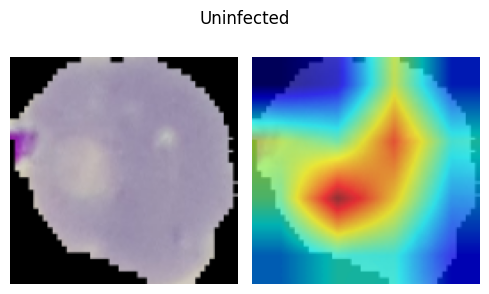

torch.Size([1, 64, 4, 4])

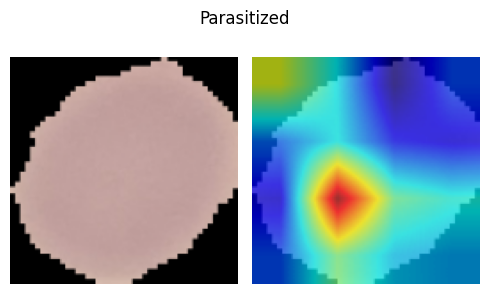

torch.Size([1, 64, 4, 4])

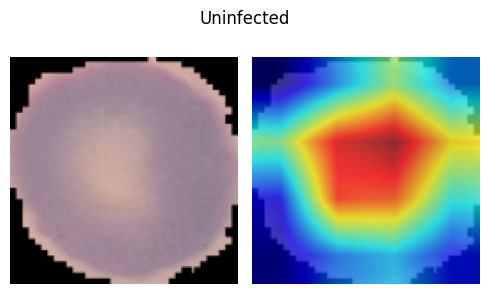

torch.Size([1, 64, 4, 4])

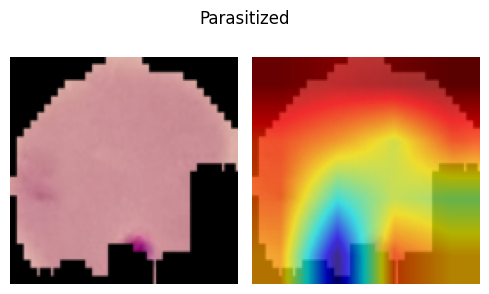

torch.Size([1, 64, 4, 4])

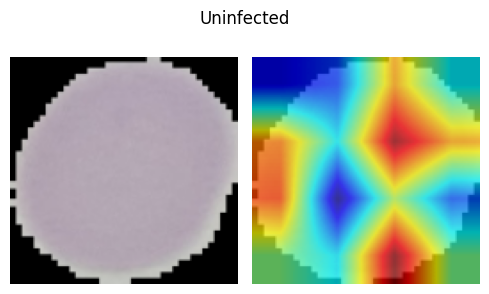

torch.Size([1, 64, 4, 4])

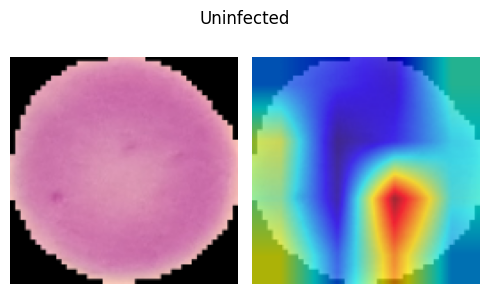

torch.Size([1, 64, 4, 4])

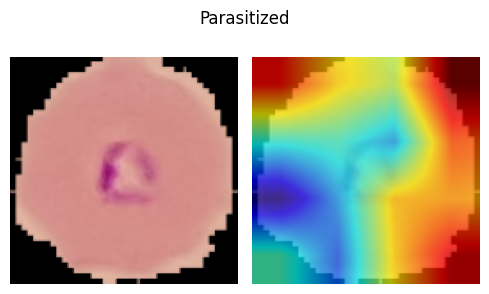

torch.Size([1, 64, 4, 4])

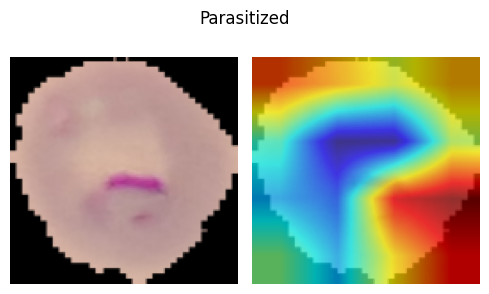

torch.Size([1, 64, 4, 4])

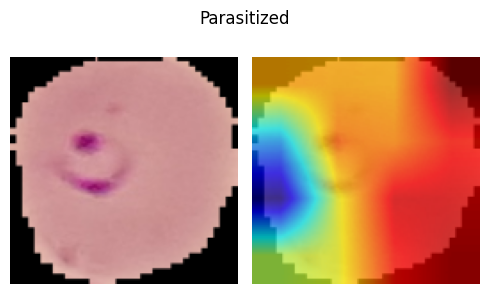

torch.Size([1, 64, 4, 4])

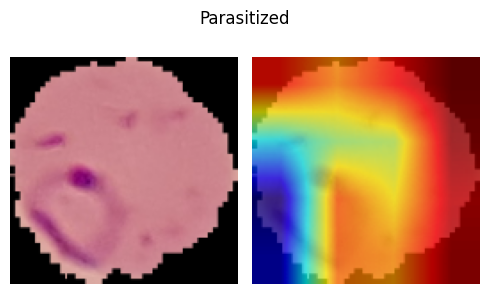

torch.Size([1, 64, 4, 4])

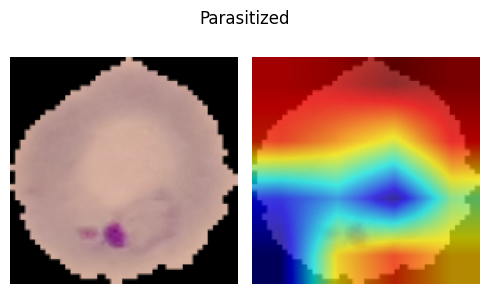

torch.Size([1, 64, 4, 4])

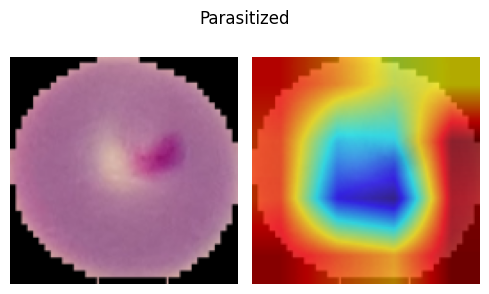

torch.Size([1, 64, 4, 4])

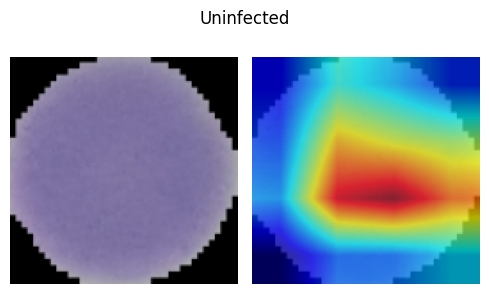

torch.Size([1, 64, 4, 4])

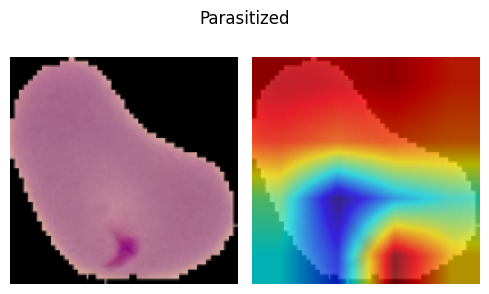

torch.Size([1, 64, 4, 4])

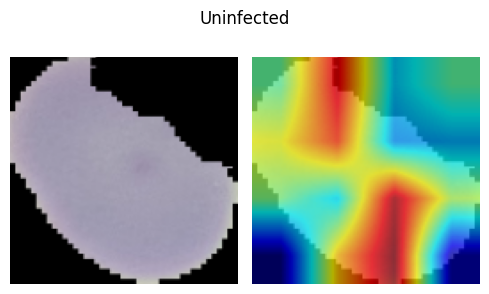

torch.Size([1, 64, 4, 4])

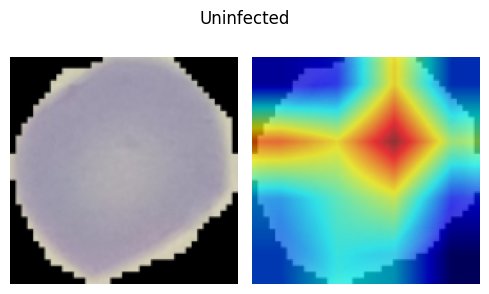

torch.Size([1, 64, 4, 4])

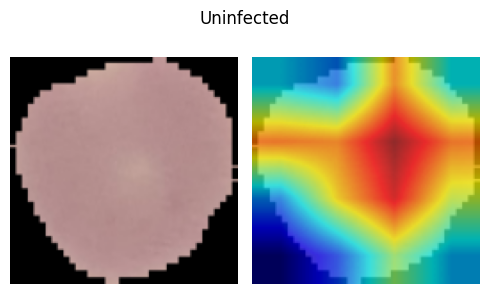

torch.Size([1, 64, 4, 4])

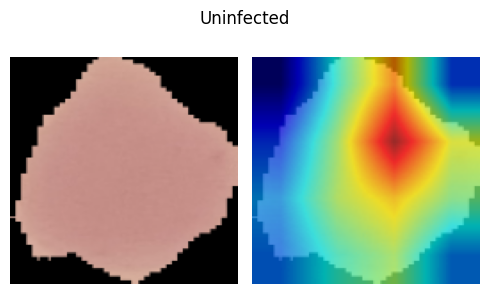

torch.Size([1, 64, 4, 4])

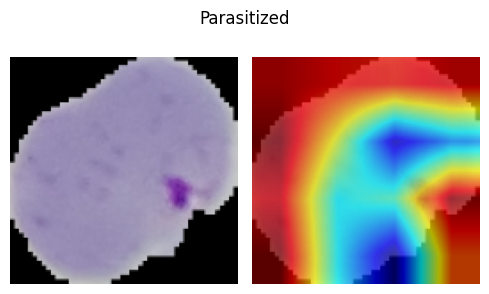

torch.Size([1, 64, 4, 4])

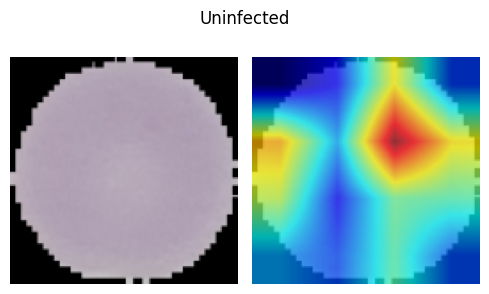

In [19]:
N = 20
_val_dl = DataLoader(valid_ds, batch_size=N, shuffle=True, collate_fn=valid_dl.collate_fn)

x, y, z = next(iter(_val_dl))

for i in range(N):
    image = resize(z[i], SZ)
    heatmap, pred = im2gradCAM(x[i:i+1])
    if (pred == 'Uinfected'):
        continue
    heatmap = upsample_heatmap(heatmap, image)
    subplots([image, heatmap], nc=2, figsize=(5, 3), suptitle=pred)